<a href="https://colab.research.google.com/github/ArghyaPal/Adversarial-Data-Programming/blob/master/Adversarial_Data_Programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Data Programming

Paucity of large curated hand-labeled training data for every domain-of-interest forms a major bottleneck in the de- ployment of machine learning models in computer vision and other fields. Recent work (Data Programming) has shown how distant supervision signals in the form of la- beling functions can be used to obtain labels for given data in near-constant time. In this work, we present Adversar- ial Data Programming (ADP), which presents an adver- sarial methodology to generate data as well as a curated aggregated label has given a set of weak labeling func- tions. We validated our method on the MNIST, Fashion MNIST, CIFAR 10 and SVHN datasets, and it outperformed many state-of-the-art models. We conducted extensive ex- periments to study its usefulness, as well as showed how the proposed ADP framework can be used for transfer learn- ing as well as multi-task learning, where data from two do- mains are generated simultaneously using the framework along with the label information. Our future work will in- volve understanding the theoretical implications of this new framework from a game-theoretic perspective, as well as explore the performance of the method on more complex datasets.

##  MNIST labeled digit generation

### Import libraries

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seem for reproducibility
#manualSeed = 999
manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  8984


### Define hyperparameters

In [0]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
img_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 50 # Please change it some higher number

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 4

### Create MNIST Dataset

0it [00:00, ?it/s]

9920512it [00:03, 3071823.04it/s]                             


Extracting gdrive/My Drive/Colab Notebooks/ADP/data/mnist/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 48885.64it/s]                           
0it [00:00, ?it/s]

Extracting gdrive/My Drive/Colab Notebooks/ADP/data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:02, 808634.26it/s]                            
0it [00:00, ?it/s]

Extracting gdrive/My Drive/Colab Notebooks/ADP/data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 18559.83it/s]            


Extracting gdrive/My Drive/Colab Notebooks/ADP/data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
cuda:0
tensor([1, 3, 1, 3, 1, 6, 7, 7, 3, 1, 2, 8, 1, 5, 7, 4, 9, 3, 1, 1, 5, 8, 8, 8,
        2, 2, 2, 6, 5, 9, 3, 9, 3, 0, 7, 8, 9, 4, 2, 0, 2, 6, 2, 0, 7, 5, 7, 6,
        0, 6, 3, 5, 3, 8, 3, 0, 7, 3, 4, 9, 5, 0, 9, 1, 1, 8, 9, 0, 0, 1, 7, 4,
        9, 7, 2, 3, 3, 8, 8, 3, 6, 0, 6, 1, 6, 7, 5, 7, 9, 8, 6, 4, 0, 2, 9, 6,
        7, 5, 1, 4, 9, 1, 8, 5, 0, 1, 0, 7, 8, 2, 1, 1, 0, 9, 9, 1, 4, 3, 1, 4,
        1, 5, 5, 6, 1, 8, 5, 3])


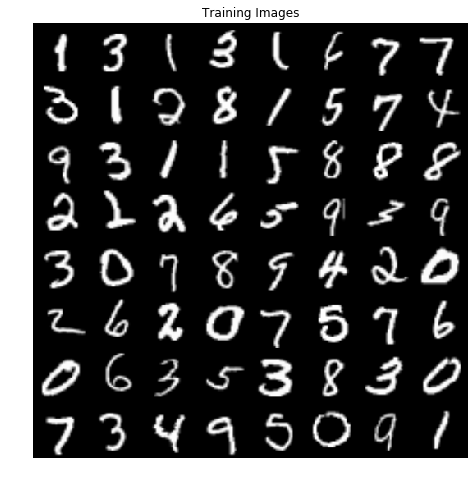

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
os.makedirs("gdrive/My Drive/Colab Notebooks/ADP/data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "gdrive/My Drive/Colab Notebooks/ADP/data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


print(device)


# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
print(real_batch[1])

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator 

In [0]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.G_common = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf*2) x 16 x 16
        )
        
        self.G_image = nn.Sequential(
            nn.ConvTranspose2d( ngf * 4, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nc),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (nc) x 64 x 64
        )
        
        self.G_label = nn.Sequential(
            nn.Conv2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf) x 8 x 8
            nn.Conv2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (nc) x 4 x 4
            nn.Conv2d( ngf, nc, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nc),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (nc) x 1 x 1
            nn.Conv2d( nc, 1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(1),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (nc) x 1 x 1
        )

    def forward(self, input):
        common = self.G_common(input)
        image = self.G_image(common)
        label = self.G_label(common)
        label = label.view(-1*1*1*1) # reshaping the tensor
        return image, label

In [6]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda:0') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (G_common): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace)
  )
  (G_image): Sequential(
    (0): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
    (

### Discriminator

In [0]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.D_image = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.D_label = nn.Sequential(
            nn.ConvTranspose2d( 10, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf*4) x 8 x 8
        )
        
        self.D_common = nn.Sequential(
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(2*ndf * 4, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf, 1, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, input, x):
        image = self.D_image(input)
        label = self.D_label(x)
        common = torch.cat([image, label], 1)
        result = self.D_common(common)
        result = result.view(-1*1*1*1)
        
        return result
        

In [8]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda:0') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (D_image): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
  )
  (D_label): Sequential(
    (0): ConvTranspose2d(10, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, e

In [0]:
# Initialize BCELoss function
criterion = nn.BCEWithLogitsLoss() #MSELoss() #nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

cuda = True if torch.cuda.is_available() else False

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

## Training the ADP

In [10]:
# Training Loop
# Note: Sigmoid and BCE is a killer ... Don't use them

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
from torch.autograd import Variable
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        real_class = data[1].to(device)
        real_class = torch.eye(10)[real_class].to(device)    # One hot encoding of class label
        real_class = real_class.view(b_size, -1, 1, 1).to(device)
        #print(real_class.shape)
        label = torch.full((b_size,), real_label, device=device)
        
        
        # Forward pass real batch through D
        output = netD(real_cpu, real_class).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake, fake_class = netG(noise)
        fake_class = Variable(fake_class.type(LongTensor))
        fake_class = torch.eye(10)[fake_class].to(device)    # One hot encoding of class label
        fake_class = fake_class.view(-1, 10, 1, 1).to(device)
        
        
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach(), fake_class.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake, fake_class).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake, a = netG(fixed_noise)
                fake = fake.detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/50][0/469]	Loss_D: 1.4975	Loss_G: 0.6089	D(x): 0.3210	D(G(z)): 0.3107 / 0.2601
[0/50][50/469]	Loss_D: 1.3953	Loss_G: 0.5843	D(x): 0.3814	D(G(z)): 0.2563 / 0.2561
[0/50][100/469]	Loss_D: 1.3982	Loss_G: 0.5841	D(x): 0.3611	D(G(z)): 0.2577 / 0.2575
[0/50][150/469]	Loss_D: 1.3428	Loss_G: 0.6245	D(x): 0.3626	D(G(z)): 0.1572 / 0.1570
[0/50][200/469]	Loss_D: 1.3617	Loss_G: 0.6128	D(x): 0.3523	D(G(z)): 0.1853 / 0.1851
[0/50][250/469]	Loss_D: 1.3490	Loss_G: 0.6250	D(x): 0.3458	D(G(z)): 0.1566 / 0.1564
[0/50][300/469]	Loss_D: 1.3774	Loss_G: 0.6066	D(x): 0.3300	D(G(z)): 0.2018 / 0.2016
[0/50][350/469]	Loss_D: 1.3705	Loss_G: 0.6138	D(x): 0.3125	D(G(z)): 0.1842 / 0.1839
[0/50][400/469]	Loss_D: 1.3697	Loss_G: 0.6184	D(x): 0.2918	D(G(z)): 0.1736 / 0.1733
[0/50][450/469]	Loss_D: 1.3663	Loss_G: 0.6229	D(x): 0.2871	D(G(z)): 0.1633 / 0.1629
[1/50][0/469]	Loss_D: 1.3634	Loss_G: 0.6243	D(x): 0.3009	D(G(z)): 0.1599 / 0.1597
[1/50][50/469]	Loss_D: 1.3391	Loss_G: 0.6457	D(x): 0.30

KeyboardInterrupt: ignored

### Visualizing result

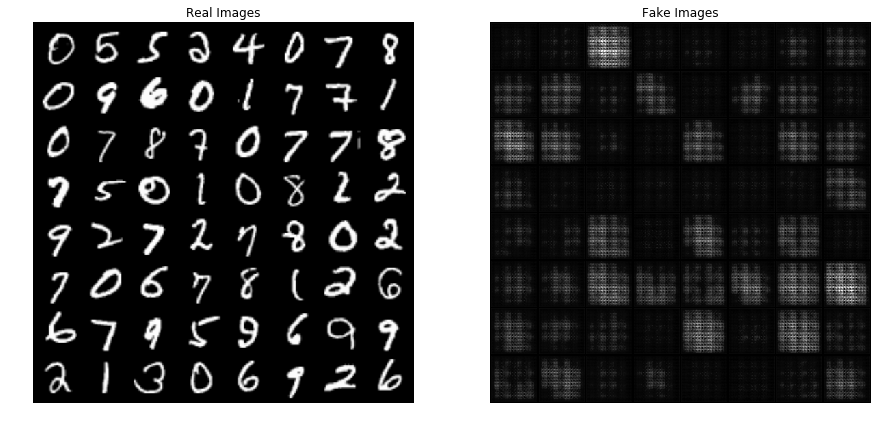

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],


In [11]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()
a = Variable(a.type(LongTensor))
a = torch.eye(10)[a].to(device)    # One hot encoding of class label
print(a)